In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import root_mean_squared_error

# Set Seaborn style
sns.set_theme(style='whitegrid')

# Define paths
RAW_DIR = Path("../data/raw")
MATLAB_DIR = Path("../src/matlab")

In [2]:
import os
import sys
# Add the 'src' folder to the Python path so project-specific modules can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))


In [3]:
# ---- Load IPCA (Inflation) ----
ipca_raw = pd.read_csv(RAW_DIR / "IBGE_20250331_183405_T118-V306_205037.csv")
ipca_two = pd.read_csv(MATLAB_DIR / "ipca_trend_two_sided.csv", header=None, names=["trend_two"])
ipca_one = pd.read_csv(MATLAB_DIR / "ipca_trend_one_sided.csv", header=None, names=["trend_one"])

ipca = ipca_raw.copy()
ipca["trend_two"] = ipca_two["trend_two"]
ipca["trend_one"] = ipca_one["trend_one"]

# --- Load GDP ---
gdp_raw = pd.read_csv(RAW_DIR / "IBGE_20250331_183405_T6613-V9319_205007.csv")
gdp_two = pd.read_csv(MATLAB_DIR / "gdp_trend_two_sided.csv", header=None, names=["trend_two"])
gdp_one = pd.read_csv(MATLAB_DIR / "gdp_trend_one_sided.csv", header=None, names=["trend_one"])

gdp = pd.DataFrame()
gdp["log_valor"] = np.log(gdp_raw["valor"])
gdp["trend_two"] = gdp_two["trend_two"]
gdp["trend_one"] = gdp_one["trend_one"]

# --- Apply BK Filter to log-GDP (remove trend, isolate cycle) ---
# Set min/max periods in quarters (e.g., 6 to 32 → 1.5 to 8 years)
bk_cycle = sm.tsa.filters.bkfilter(gdp["log_valor"], low=6, high=32, K=12)
bks_cycle = sm.tsa.filters.bkfilter(gdp["log_valor"], low=6, high=32, K=40)

# Extract trend by subtracting the cycle from the original
gdp["bk_trend"] = gdp["log_valor"] - bk_cycle
gdp["bks_trend"] = gdp["log_valor"] - bks_cycle


In [4]:
# --- Apply Python HP Filter ---
_, ipca_trend_py = sm.tsa.filters.hpfilter(ipca["valor"], lamb=129600)
_, gdp_trend_py  = sm.tsa.filters.hpfilter(gdp["log_valor"], lamb=1600)

# --- Compute RMSE ---
ipca_rmse = root_mean_squared_error(ipca["trend_two"], ipca_trend_py)
gdp_rmse  = root_mean_squared_error(gdp["trend_two"], gdp_trend_py)

# --- Print Results ---
print(f"RMSE between MATLAB and Python trends:")
print(f"- IPCA trend (percent):       {ipca_rmse:.6f}")
print(f"- GDP trend (log of level):   {gdp_rmse:.6f}")


RMSE between MATLAB and Python trends:
- IPCA trend (percent):       0.000000
- GDP trend (log of level):   0.000000


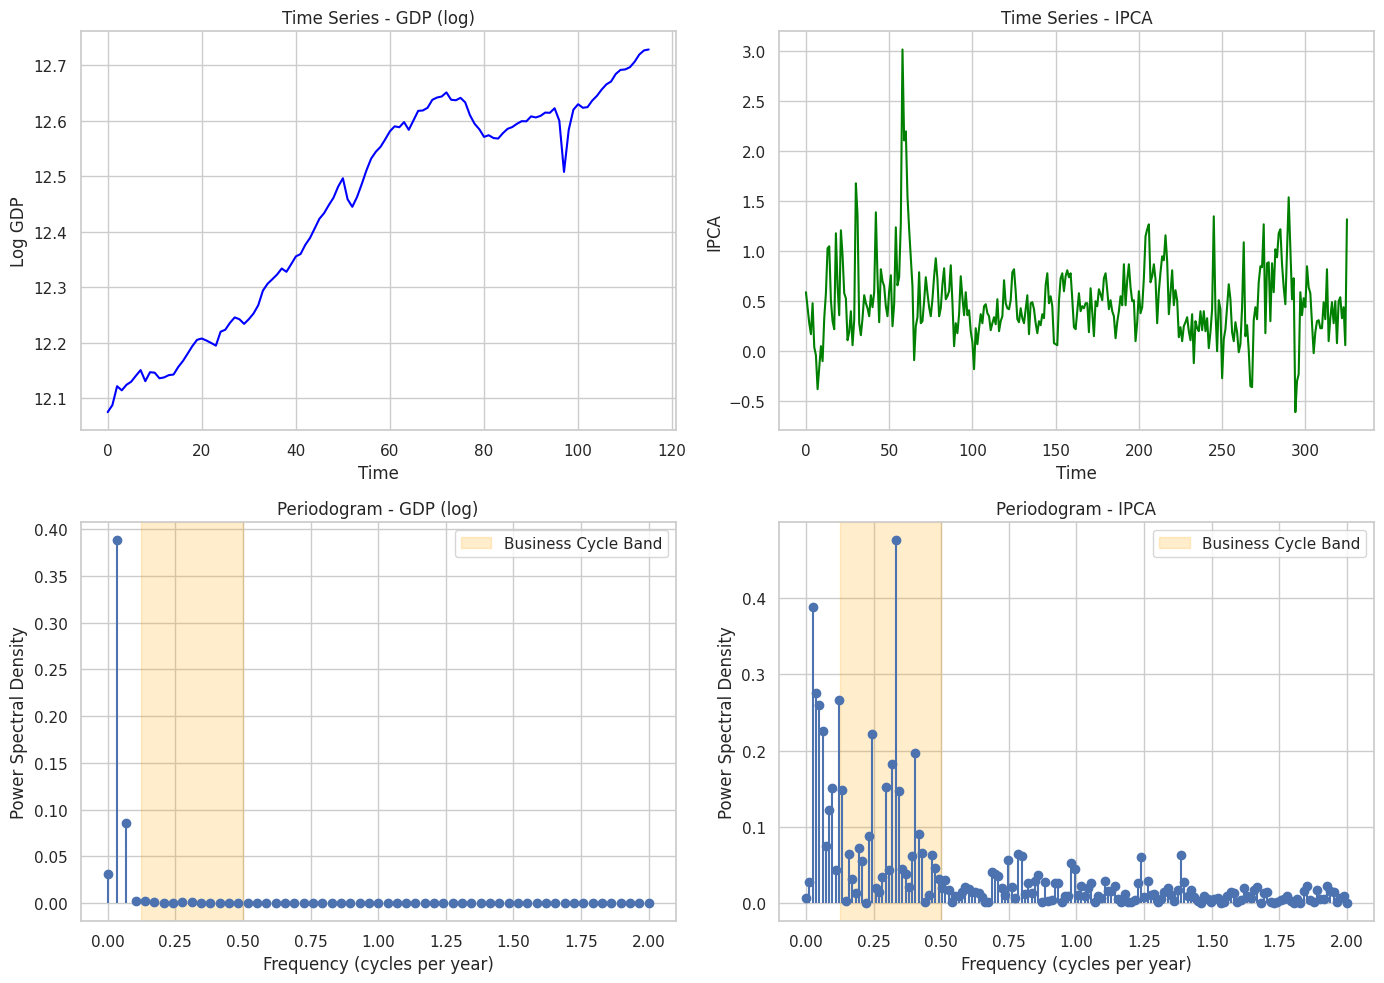

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# Assuming gdp and ipca are your DataFrames
gdp_series = gdp['log_valor'].dropna()
ipca_series = ipca['valor'].dropna()

# Sampling frequency (quarterly data)
fs = 4

# Compute periodograms
freqs_gdp, psd_gdp = periodogram(gdp_series.values, fs=fs, window='hann', scaling='density')
freqs_ipca, psd_ipca = periodogram(ipca_series.values, fs=fs, window='hann', scaling='density')

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- GDP Time Series Plot ---
axes[0, 0].plot(gdp_series.index, gdp_series.values, color='blue')
axes[0, 0].set_title("Time Series - GDP (log)")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Log GDP")
axes[0, 0].grid(True)

# --- IPCA Time Series Plot ---
axes[0, 1].plot(ipca_series.index, ipca_series.values, color='green')
axes[0, 1].set_title("Time Series - IPCA")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("IPCA")
axes[0, 1].grid(True)

# --- GDP Periodogram ---
axes[1, 0].stem(freqs_gdp, psd_gdp, basefmt=" ")
axes[1, 0].axvspan(0.125, 0.5, color='orange', alpha=0.2, label='Business Cycle Band')
axes[1, 0].set_title("Periodogram - GDP (log)")
axes[1, 0].set_xlabel("Frequency (cycles per year)")
axes[1, 0].set_ylabel("Power Spectral Density")
axes[1, 0].grid(True)

# --- IPCA Periodogram ---
axes[1, 1].stem(freqs_ipca, psd_ipca, basefmt=" ")
axes[1, 1].axvspan(0.125, 0.5, color='orange', alpha=0.2, label='Business Cycle Band')
axes[1, 1].set_title("Periodogram - IPCA")
axes[1, 1].set_xlabel("Frequency (cycles per year)")
axes[1, 1].set_ylabel("Power Spectral Density")
axes[1, 1].grid(True)

# Optional: Add legends to periodograms to explain the shaded area
axes[1, 0].legend(loc="upper right")
axes[1, 1].legend(loc="upper right")

plt.tight_layout()
plt.show()


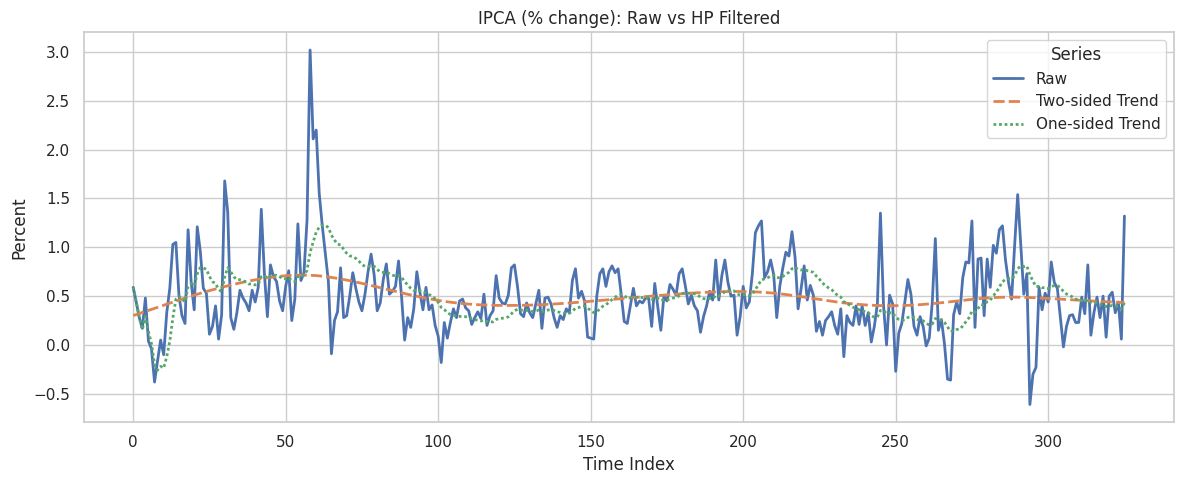

In [5]:
# Melt data for Seaborn
ipca_plot = ipca[["valor", "trend_two", "trend_one"]].copy()
ipca_plot.columns = ["Raw", "Two-sided Trend", "One-sided Trend"]
ipca_plot = ipca_plot.reset_index().melt(id_vars="index", var_name="Series", value_name="Value")

# Plot using default style and palette
plt.figure(figsize=(12, 5))
sns.lineplot(data=ipca_plot, x="index", y="Value", hue="Series", style="Series", linewidth=2)
plt.title("IPCA (% change): Raw vs HP Filtered")
plt.xlabel("Time Index")
plt.ylabel("Percent")
plt.legend(title="Series")
plt.tight_layout()
plt.show()


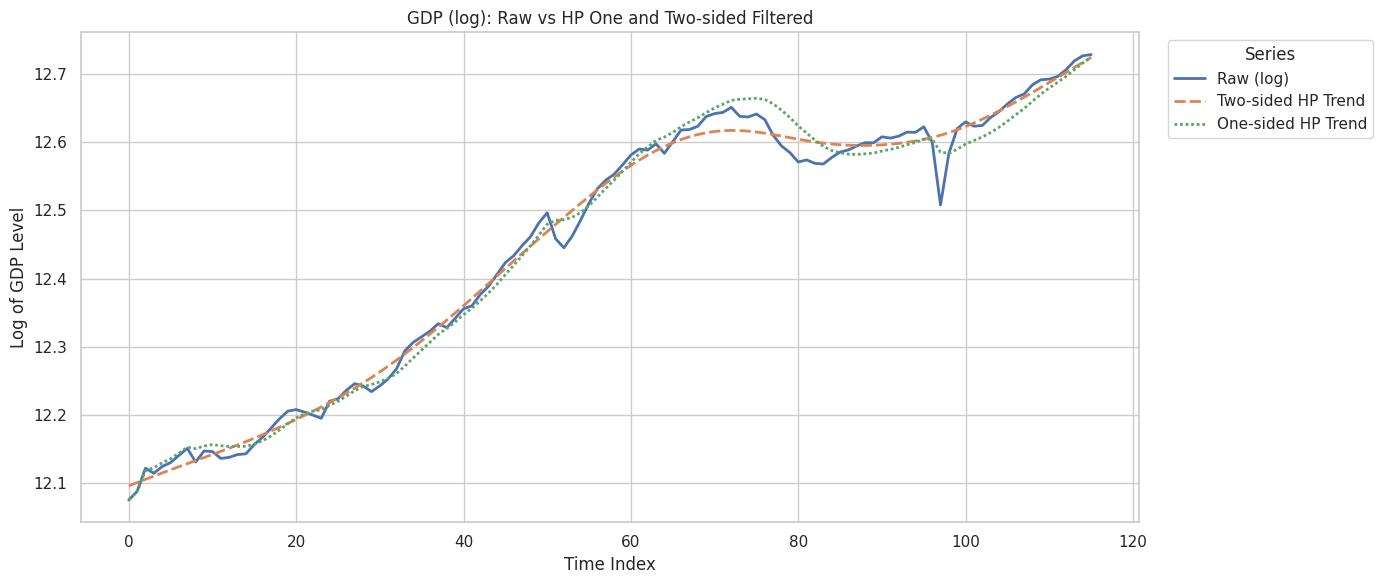

In [39]:
# --- Rename columns for consistent labeling ---
gdp_plot = gdp[[
    "log_valor", 
    "trend_two", 
    "trend_one", 
    #"bk_trend", 
    #"bks_trend"
    ]].copy()
gdp_plot.columns = [
    "Raw (log)",
    "Two-sided HP Trend",
    "One-sided HP Trend",
    #"BK Trend (K=12)",
    #"BK Trend (K=40)"
]

# --- Melt for Seaborn ---
gdp_plot = gdp_plot.reset_index().melt(
    id_vars="index",
    var_name="Series",
    value_name="Value"
)

# --- Plot ---
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=gdp_plot,
    x="index",
    y="Value",
    hue="Series",
    style="Series",
    linewidth=2
)
plt.title("GDP (log): Raw vs HP One and Two-sided Filtered")
plt.xlabel("Time Index")
plt.ylabel("Log of GDP Level")
plt.legend(title="Series", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


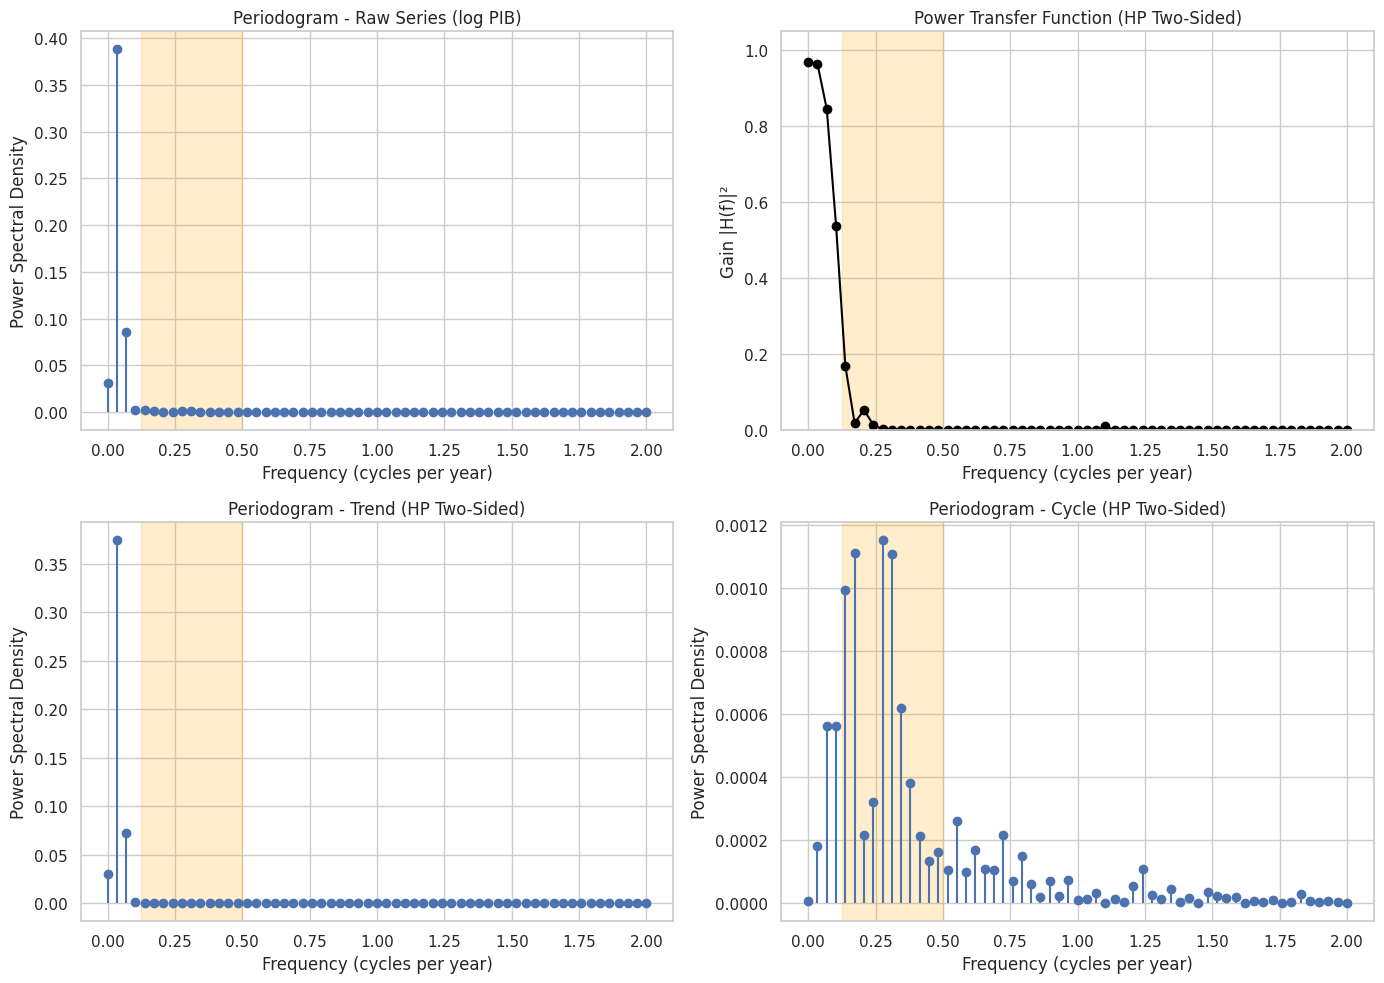

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# --- Dados ---
gdp_series = gdp["log_valor"].dropna().values
trend_two = gdp["trend_two"].dropna().values
cycle_two = gdp_series - trend_two  # Ciclo = Série original - tendência

# --- Parâmetros ---
fs = 4  # Dados trimestrais

# --- Periodogramas ---
freqs, psd_raw = periodogram(gdp_series, fs=fs, window='hann', scaling='density')
_, psd_trend = periodogram(trend_two, fs=fs, window='hann', scaling='density')
_, psd_cycle = periodogram(cycle_two, fs=fs, window='hann', scaling='density')

# --- Power Transfer Function (PTF) ---
ptf = psd_trend / psd_raw
ptf = np.nan_to_num(ptf)  # Corrige divisões por zero se houver

# --- Plotagem ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- (1,1) Periodograma da Série Raw ---
axes[0, 0].stem(freqs, psd_raw, basefmt=" ")
axes[0, 0].set_title("Periodogram - Raw Series (log PIB)")
axes[0, 0].set_xlabel("Frequency (cycles per year)")
axes[0, 0].set_ylabel("Power Spectral Density")
axes[0, 0].grid(True)

# --- (1,2) Power Transfer Function (PTF) ---
axes[0, 1].plot(freqs, ptf, marker='o', color='black')
axes[0, 1].set_title("Power Transfer Function (HP Two-Sided)")
axes[0, 1].set_xlabel("Frequency (cycles per year)")
axes[0, 1].set_ylabel("Gain |H(f)|²")
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].grid(True)

# --- (2,1) Periodograma da Tendência ---
axes[1, 0].stem(freqs, psd_trend, basefmt=" ")
axes[1, 0].set_title("Periodogram - Trend (HP Two-Sided)")
axes[1, 0].set_xlabel("Frequency (cycles per year)")
axes[1, 0].set_ylabel("Power Spectral Density")
axes[1, 0].grid(True)

# --- (2,2) Periodograma do Ciclo ---
axes[1, 1].stem(freqs, psd_cycle, basefmt=" ")
axes[1, 1].set_title("Periodogram - Cycle (HP Two-Sided)")
axes[1, 1].set_xlabel("Frequency (cycles per year)")
axes[1, 1].set_ylabel("Power Spectral Density")
axes[1, 1].grid(True)

# --- Destacar faixa de ciclo econômico em todos ---
for ax in axes.flat:
    ax.axvspan(0.125, 0.5, color='orange', alpha=0.2)

plt.tight_layout()
plt.show()


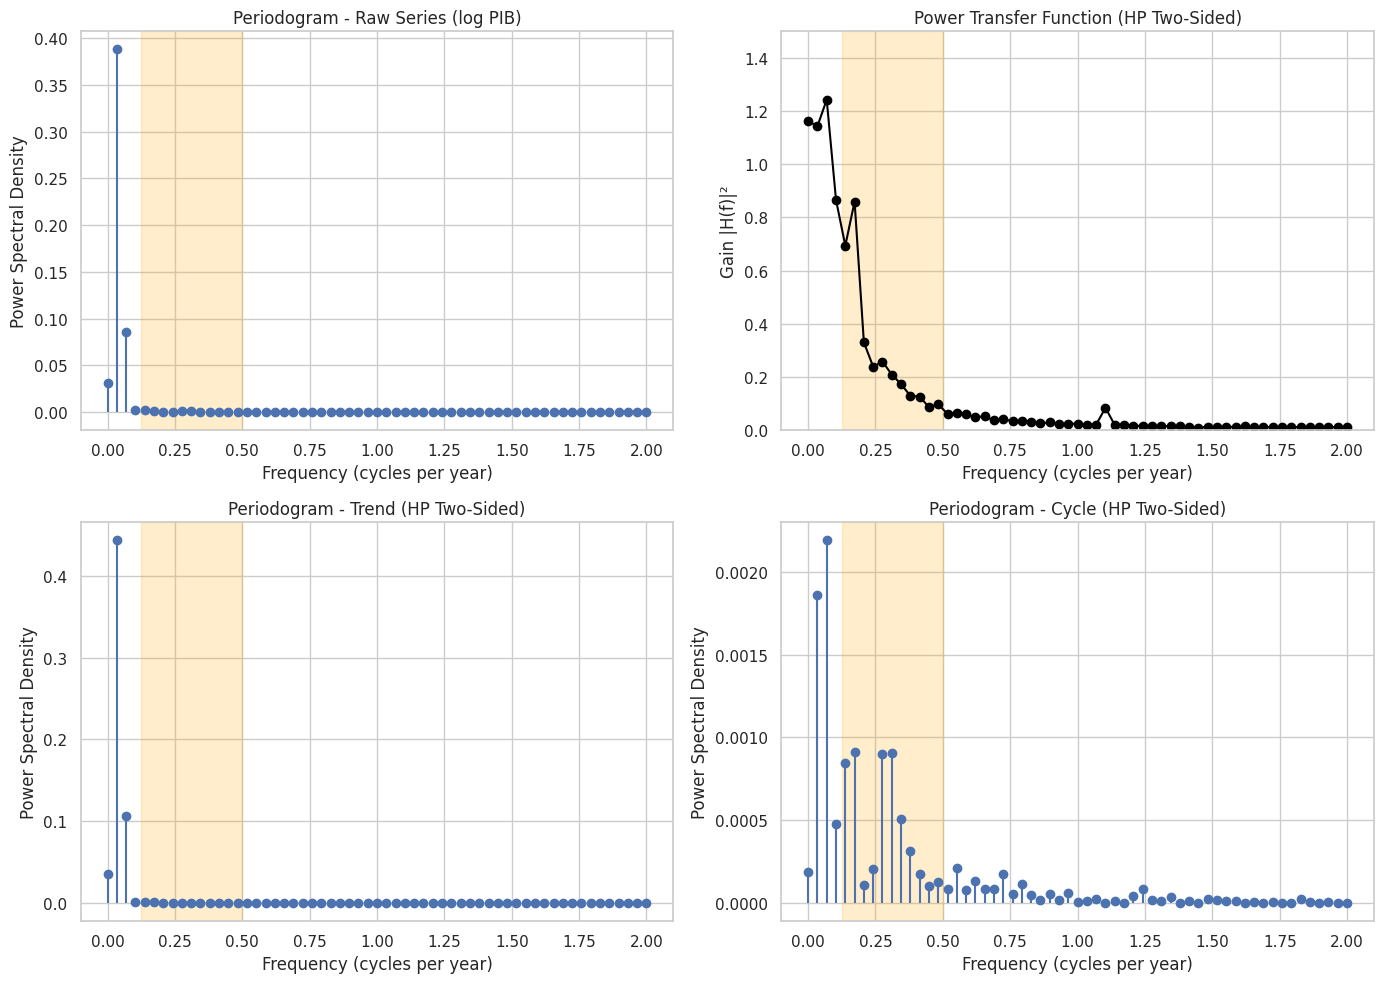

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# --- Dados ---
gdp_series = gdp["log_valor"].dropna().values
trend_two = gdp["trend_one"].dropna().values
cycle_two = gdp_series - trend_two  # Ciclo = Série original - tendência

# --- Parâmetros ---
fs = 4  # Dados trimestrais

# --- Periodogramas ---
freqs, psd_raw = periodogram(gdp_series, fs=fs, window='hann', scaling='density')
_, psd_trend = periodogram(trend_two, fs=fs, window='hann', scaling='density')
_, psd_cycle = periodogram(cycle_two, fs=fs, window='hann', scaling='density')

# --- Power Transfer Function (PTF) ---
ptf = psd_trend / psd_raw
ptf = np.nan_to_num(ptf)  # Corrige divisões por zero se houver

# --- Plotagem ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- (1,1) Periodograma da Série Raw ---
axes[0, 0].stem(freqs, psd_raw, basefmt=" ")
axes[0, 0].set_title("Periodogram - Raw Series (log PIB)")
axes[0, 0].set_xlabel("Frequency (cycles per year)")
axes[0, 0].set_ylabel("Power Spectral Density")
axes[0, 0].grid(True)

# --- (1,2) Power Transfer Function (PTF) ---
axes[0, 1].plot(freqs, ptf, marker='o', color='black')
axes[0, 1].set_title("Power Transfer Function (HP Two-Sided)")
axes[0, 1].set_xlabel("Frequency (cycles per year)")
axes[0, 1].set_ylabel("Gain |H(f)|²")
axes[0, 1].set_ylim(0, 1.50)
axes[0, 1].grid(True)

# --- (2,1) Periodograma da Tendência ---
axes[1, 0].stem(freqs, psd_trend, basefmt=" ")
axes[1, 0].set_title("Periodogram - Trend (HP Two-Sided)")
axes[1, 0].set_xlabel("Frequency (cycles per year)")
axes[1, 0].set_ylabel("Power Spectral Density")
axes[1, 0].grid(True)

# --- (2,2) Periodograma do Ciclo ---
axes[1, 1].stem(freqs, psd_cycle, basefmt=" ")
axes[1, 1].set_title("Periodogram - Cycle (HP Two-Sided)")
axes[1, 1].set_xlabel("Frequency (cycles per year)")
axes[1, 1].set_ylabel("Power Spectral Density")
axes[1, 1].grid(True)

# --- Destacar faixa de ciclo econômico em todos ---
for ax in axes.flat:
    ax.axvspan(0.125, 0.5, color='orange', alpha=0.2)

plt.tight_layout()
plt.show()


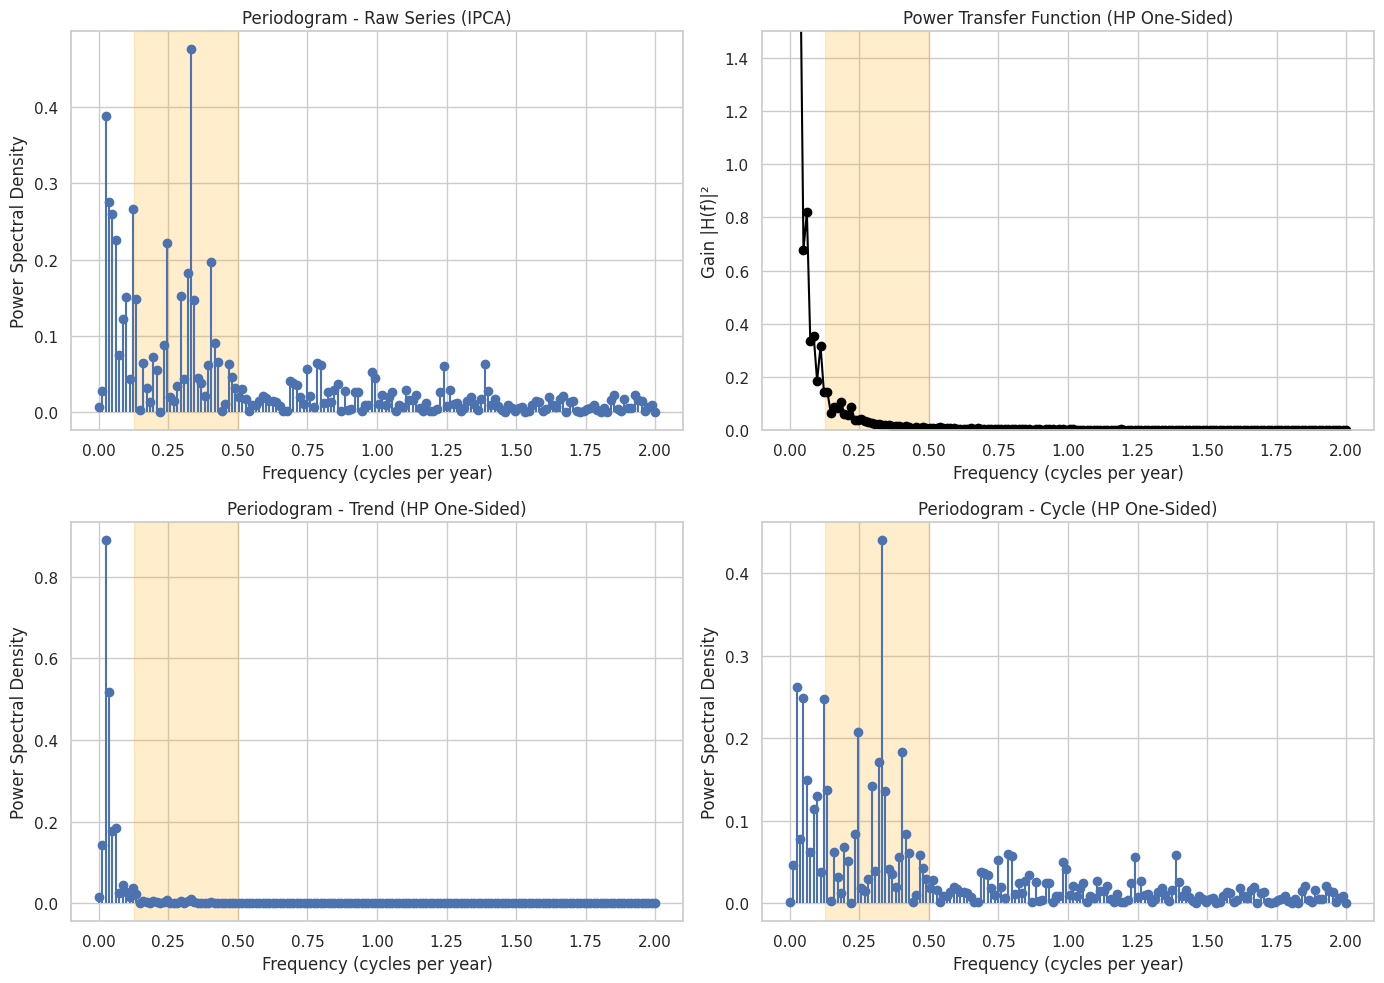

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# --- Dados ---
gdp_series = ipca["valor"].dropna().values
trend_two = ipca["trend_one"].dropna().values
cycle_two = gdp_series - trend_two  # Ciclo = Série original - tendência

# --- Parâmetros ---
fs = 4  # Dados trimestrais

# --- Periodogramas ---
freqs, psd_raw = periodogram(gdp_series, fs=fs, window='hann', scaling='density')
_, psd_trend = periodogram(trend_two, fs=fs, window='hann', scaling='density')
_, psd_cycle = periodogram(cycle_two, fs=fs, window='hann', scaling='density')

# --- Power Transfer Function (PTF) ---
ptf = psd_trend / psd_raw
ptf = np.nan_to_num(ptf)  # Corrige divisões por zero se houver

# --- Plotagem ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- (1,1) Periodograma da Série Raw ---
axes[0, 0].stem(freqs, psd_raw, basefmt=" ")
axes[0, 0].set_title("Periodogram - Raw Series (IPCA)")
axes[0, 0].set_xlabel("Frequency (cycles per year)")
axes[0, 0].set_ylabel("Power Spectral Density")
axes[0, 0].grid(True)

# --- (1,2) Power Transfer Function (PTF) ---
axes[0, 1].plot(freqs, ptf, marker='o', color='black')
axes[0, 1].set_title("Power Transfer Function (HP One-Sided)")
axes[0, 1].set_xlabel("Frequency (cycles per year)")
axes[0, 1].set_ylabel("Gain |H(f)|²")
axes[0, 1].set_ylim(0, 1.5)
axes[0, 1].grid(True)

# --- (2,1) Periodograma da Tendência ---
axes[1, 0].stem(freqs, psd_trend, basefmt=" ")
axes[1, 0].set_title("Periodogram - Trend (HP One-Sided)")
axes[1, 0].set_xlabel("Frequency (cycles per year)")
axes[1, 0].set_ylabel("Power Spectral Density")
axes[1, 0].grid(True)

# --- (2,2) Periodograma do Ciclo ---
axes[1, 1].stem(freqs, psd_cycle, basefmt=" ")
axes[1, 1].set_title("Periodogram - Cycle (HP One-Sided)")
axes[1, 1].set_xlabel("Frequency (cycles per year)")
axes[1, 1].set_ylabel("Power Spectral Density")
axes[1, 1].grid(True)

# --- Destacar faixa de ciclo econômico em todos ---
for ax in axes.flat:
    ax.axvspan(0.125, 0.5, color='orange', alpha=0.2)

plt.tight_layout()
plt.show()


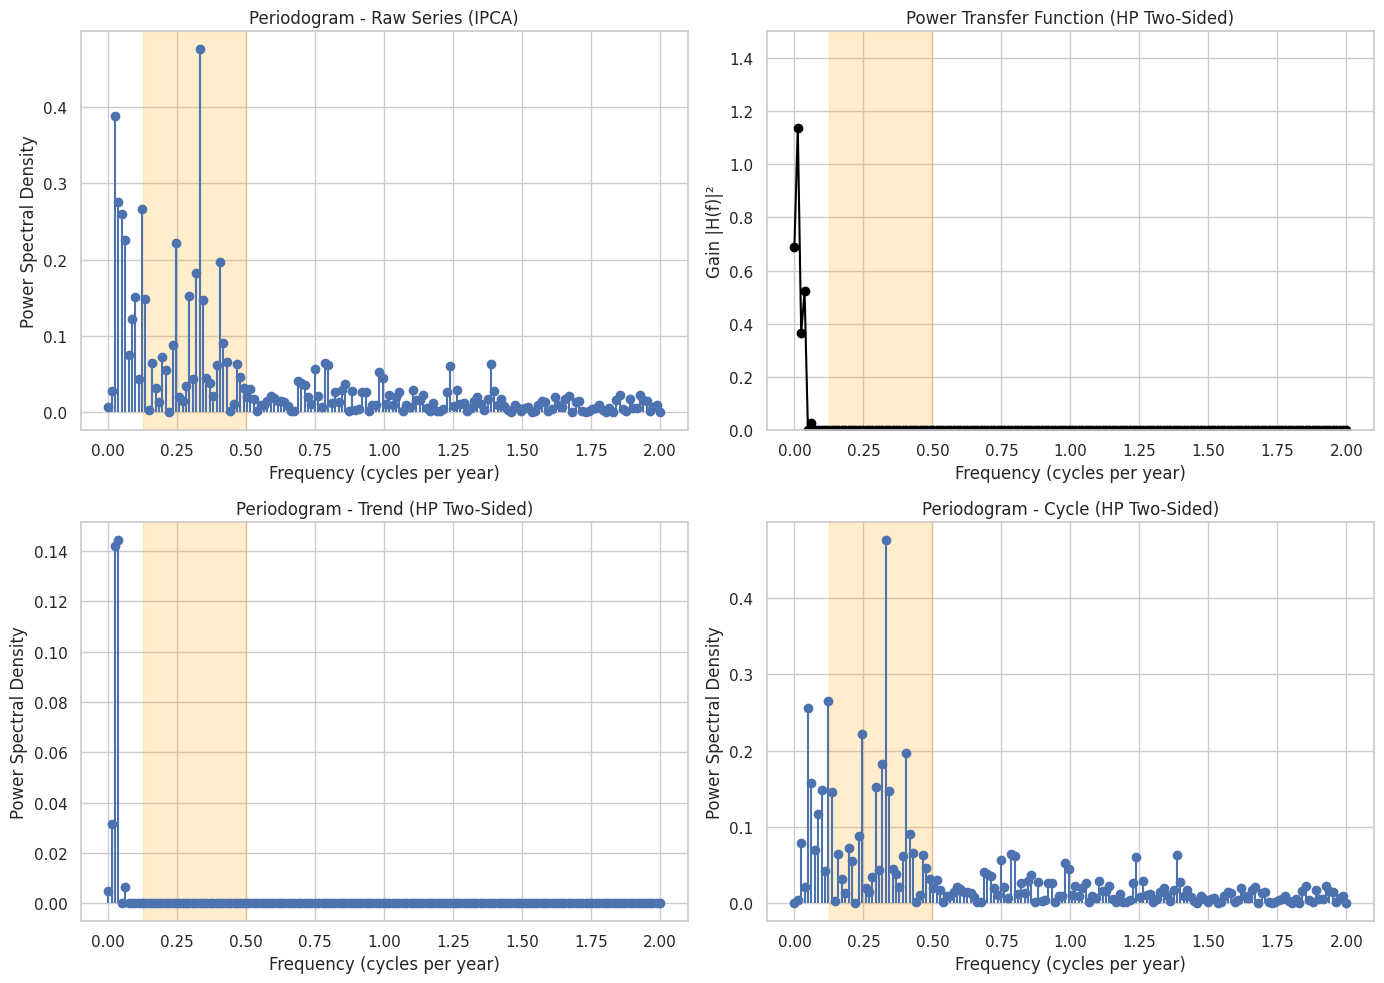

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# --- Dados ---
gdp_series = ipca["valor"].dropna().values
trend_two = ipca["trend_two"].dropna().values
cycle_two = gdp_series - trend_two  # Ciclo = Série original - tendência

# --- Parâmetros ---
fs = 4  # Dados trimestrais

# --- Periodogramas ---
freqs, psd_raw = periodogram(gdp_series, fs=fs, window='hann', scaling='density')
_, psd_trend = periodogram(trend_two, fs=fs, window='hann', scaling='density')
_, psd_cycle = periodogram(cycle_two, fs=fs, window='hann', scaling='density')

# --- Power Transfer Function (PTF) ---
ptf = psd_trend / psd_raw
ptf = np.nan_to_num(ptf)  # Corrige divisões por zero se houver

# --- Plotagem ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- (1,1) Periodograma da Série Raw ---
axes[0, 0].stem(freqs, psd_raw, basefmt=" ")
axes[0, 0].set_title("Periodogram - Raw Series (IPCA)")
axes[0, 0].set_xlabel("Frequency (cycles per year)")
axes[0, 0].set_ylabel("Power Spectral Density")
axes[0, 0].grid(True)

# --- (1,2) Power Transfer Function (PTF) ---
axes[0, 1].plot(freqs, ptf, marker='o', color='black')
axes[0, 1].set_title("Power Transfer Function (HP Two-Sided)")
axes[0, 1].set_xlabel("Frequency (cycles per year)")
axes[0, 1].set_ylabel("Gain |H(f)|²")
axes[0, 1].set_ylim(0, 1.5)
axes[0, 1].grid(True)

# --- (2,1) Periodograma da Tendência ---
axes[1, 0].stem(freqs, psd_trend, basefmt=" ")
axes[1, 0].set_title("Periodogram - Trend (HP Two-Sided)")
axes[1, 0].set_xlabel("Frequency (cycles per year)")
axes[1, 0].set_ylabel("Power Spectral Density")
axes[1, 0].grid(True)

# --- (2,2) Periodograma do Ciclo ---
axes[1, 1].stem(freqs, psd_cycle, basefmt=" ")
axes[1, 1].set_title("Periodogram - Cycle (HP Two-Sided)")
axes[1, 1].set_xlabel("Frequency (cycles per year)")
axes[1, 1].set_ylabel("Power Spectral Density")
axes[1, 1].grid(True)

# --- Destacar faixa de ciclo econômico em todos ---
for ax in axes.flat:
    ax.axvspan(0.125, 0.5, color='orange', alpha=0.2)

plt.tight_layout()
plt.show()


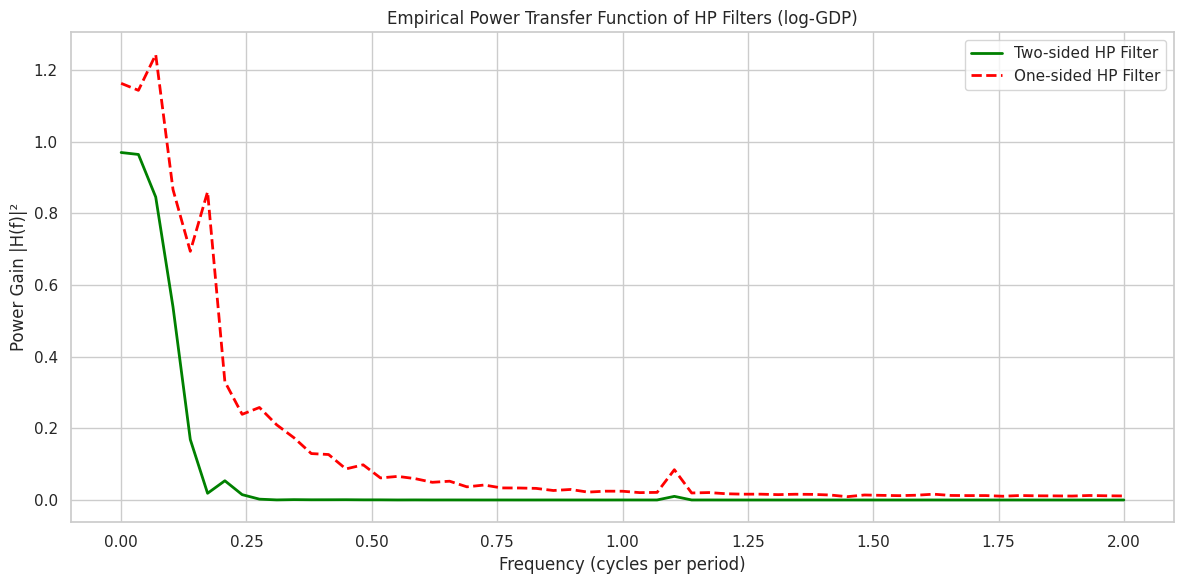

In [19]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

# --- Input signal (log-GDP) ---
gdp_input = gdp["log_valor"].values

# --- Outputs from MATLAB HP filters ---
gdp_trend_two = gdp["trend_two"].values
gdp_trend_one = gdp["trend_one"].values

# --- Compute Power Spectral Densities (PSD) ---
freqs, psd_input = periodogram(gdp_input, fs=4, scaling='density', window='hann')
_, psd_two = periodogram(gdp_trend_two, fs=4, scaling='density', window='hann')
_, psd_one = periodogram(gdp_trend_one, fs=4, scaling='density', window='hann')

# --- Compute Empirical Power Transfer Functions ---
ptf_two = psd_two / psd_input
ptf_one = psd_one / psd_input

# Handle any numerical issues
ptf_two = np.nan_to_num(ptf_two)
ptf_one = np.nan_to_num(ptf_one)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(freqs, ptf_two, label="Two-sided HP Filter", color='green', linewidth=2)
plt.plot(freqs, ptf_one, label="One-sided HP Filter", color='red', linestyle='--', linewidth=2)

plt.title("Empirical Power Transfer Function of HP Filters (log-GDP)")
plt.xlabel("Frequency (cycles per period)")
plt.ylabel("Power Gain |H(f)|²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


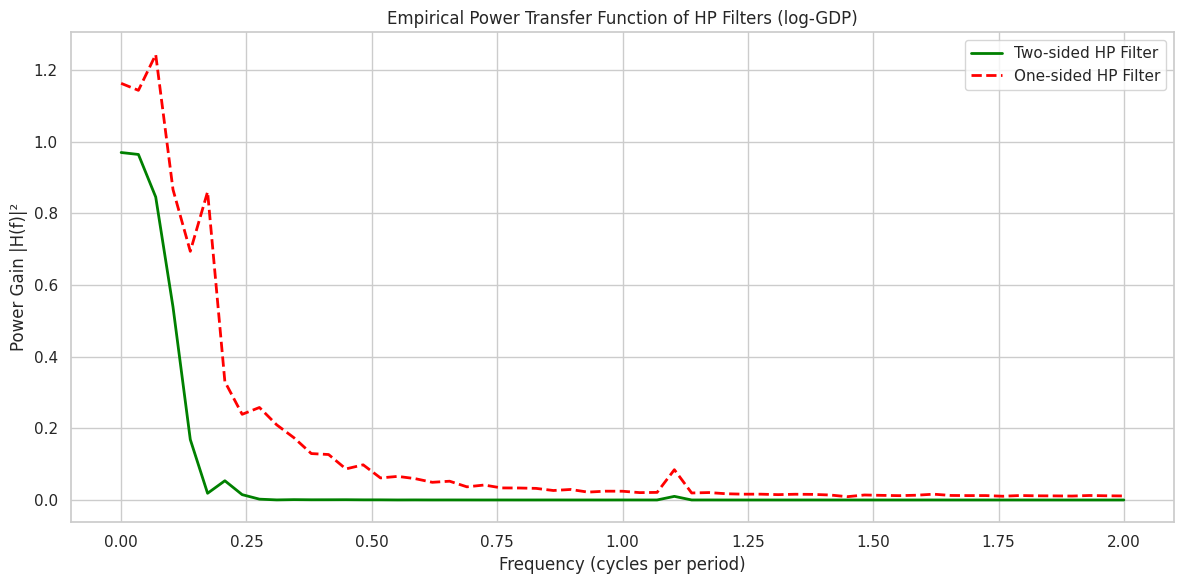

In [10]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

# --- Input signal (log-GDP) ---
gdp_input = gdp["log_valor"].values

# --- Outputs from MATLAB HP filters ---
gdp_trend_two = gdp["trend_two"].values
gdp_trend_one = gdp["trend_one"].values

# --- Compute Power Spectral Densities (PSD) ---
freqs, psd_input = periodogram(gdp_input, fs=4, scaling='density', window='hann')
_, psd_two = periodogram(gdp_trend_two, fs=4, scaling='density', window='hann')
_, psd_one = periodogram(gdp_trend_one, fs=4, scaling='density', window='hann')

# --- Compute Empirical Power Transfer Functions ---
ptf_two = psd_two / psd_input
ptf_one = psd_one / psd_input

# Handle any numerical issues
ptf_two = np.nan_to_num(ptf_two)
ptf_one = np.nan_to_num(ptf_one)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(freqs, ptf_two, label="Two-sided HP Filter", color='green', linewidth=2)
plt.plot(freqs, ptf_one, label="One-sided HP Filter", color='red', linestyle='--', linewidth=2)

plt.title("Empirical Power Transfer Function of HP Filters (log-GDP)")
plt.xlabel("Frequency (cycles per period)")
plt.ylabel("Power Gain |H(f)|²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


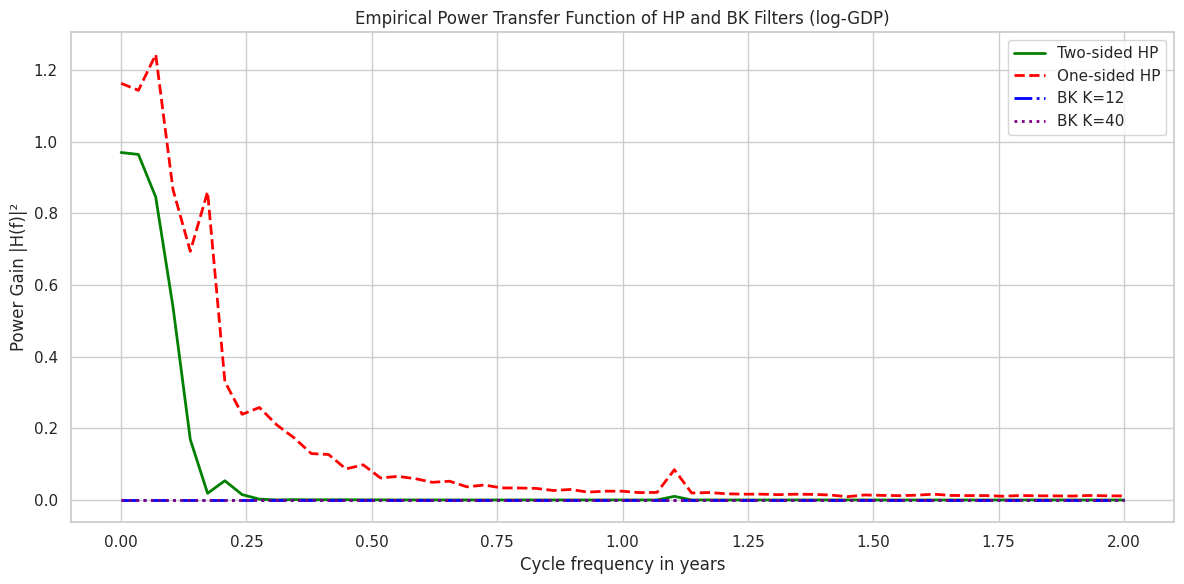

In [25]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

# --- Input signal (log-GDP) ---
gdp_input = gdp["log_valor"].values
gdp_trend_two = gdp["trend_two"].values
gdp_trend_one = gdp["trend_one"].values
gdp_trend_bk12 = gdp["bk_trend"].values
gdp_trend_bk40 = gdp["bks_trend"].values

# --- Compute PSD with correct sampling frequency (quarterly = 4/year) ---
freqs, psd_input = periodogram(gdp_input, fs=4, scaling='density', window='hann')
_, psd_two = periodogram(gdp_trend_two, fs=4, scaling='density', window='hann')
_, psd_one = periodogram(gdp_trend_one, fs=4, scaling='density', window='hann')
_, psd_bk12 = periodogram(gdp_trend_bk12, fs=4, scaling='density', window='hann')
_, psd_bk40 = periodogram(gdp_trend_bk40, fs=4, scaling='density', window='hann')

# --- Compute Empirical Power Transfer Functions ---
ptf_two = np.nan_to_num(psd_two / psd_input)
ptf_one = np.nan_to_num(psd_one / psd_input)
ptf_bk12 = np.nan_to_num(psd_bk12 / psd_input)
ptf_bk40 = np.nan_to_num(psd_bk40 / psd_input)

# --- Convert frequency to cycle length in years ---
cycle_length_years = freqs

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(cycle_length_years, ptf_two, label="Two-sided HP", color='green', linewidth=2)
plt.plot(cycle_length_years, ptf_one, label="One-sided HP", color='red', linestyle='--', linewidth=2)
plt.plot(cycle_length_years, ptf_bk12, label="BK K=12", color='blue', linestyle='-.', linewidth=2)
plt.plot(cycle_length_years, ptf_bk40, label="BK K=40", color='purple', linestyle=':', linewidth=2)



plt.title("Empirical Power Transfer Function of HP and BK Filters (log-GDP)")
plt.xlabel("Cycle frequency in years")
plt.ylabel("Power Gain |H(f)|²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_19098/2762125446.py:20: RuntimeWarning: divide by zero encountered in divide
  cycle_length_years = 1 / freqs


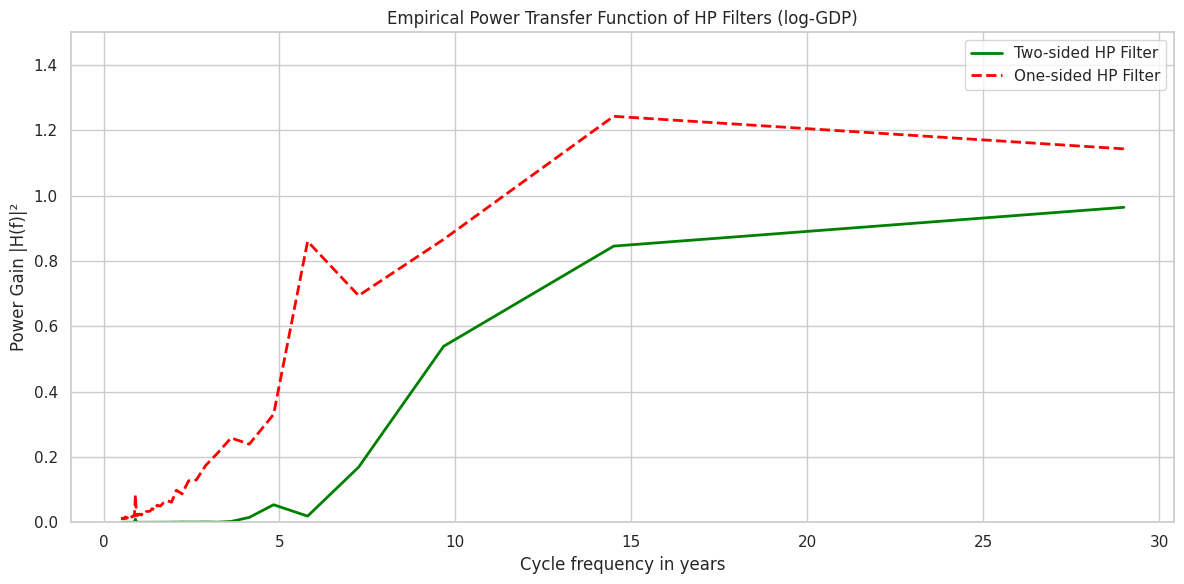

In [34]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

# --- Input signal (log-GDP) ---
gdp_input = gdp["log_valor"].values
gdp_trend_two = gdp["trend_two"].values
gdp_trend_one = gdp["trend_one"].values

# --- Compute PSD with proper sampling frequency (quarterly = 4/year) ---
freqs, psd_input = periodogram(gdp_input, fs=4, scaling='density', window='hann')
_, psd_two = periodogram(gdp_trend_two, fs=4, scaling='density', window='hann')
_, psd_one = periodogram(gdp_trend_one, fs=4, scaling='density', window='hann')

# --- Compute Transfer Functions ---
ptf_two = np.nan_to_num(psd_two / psd_input)
ptf_one = np.nan_to_num(psd_one / psd_input)

# --- Convert frequency to cycle length in years ---
cycle_length_years = 1 / freqs

# Remove freq=0 to avoid inf values
valid = np.isfinite(cycle_length_years) & (cycle_length_years > 0)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(cycle_length_years[valid], ptf_two[valid], label="Two-sided HP Filter", color='green', linewidth=2)
plt.plot(cycle_length_years[valid], ptf_one[valid], label="One-sided HP Filter", color='red', linestyle='--', linewidth=2)

#plt.xscale("log")
#plt.xlim(30, 0.5)  # Invert axis: left = long cycles
plt.ylim(0, 1.5)

plt.title("Empirical Power Transfer Function of HP Filters (log-GDP)")
plt.xlabel("Cycle frequency in years")
plt.ylabel("Power Gain |H(f)|²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
